# Import Dependencies

In [1]:
import tensorflow as tf
import cv2
import os
import gdown
import imageio
from typing import List
import matplotlib.pyplot as plt

# Load Data

In [3]:
data_url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(data_url, output, quiet=False)
gdown.extractall(output)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=d17845f1-d106-4c97-8823-0cce896387e6
To: d:\Lip_Read_App\data.zip
100%|██████████| 423M/423M [03:22<00:00, 2.09MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [11]:
f=os.path.basename('dir\\file.png')
os.path.splitext(f)

('file', '.png')

In [3]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frame = frame[190:236,80:220,:]
        frames.append(frame)
    
    cap.release()
    #standerdize images
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast(frames-mean,tf.float32)/std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token='')

In [9]:
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [14]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [16]:
encoding = num_to_char([14,  9,  3, 11])

In [29]:
[x.decode('utf-8') for x in encoding.numpy()]

['n', 'i', 'c', 'k']

In [55]:
def load_alignments(path:str) -> List[str]:
    tokens = []
    with open(path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line = line.split()
        if not line[2] == 'sil':
            tokens = [*tokens,line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),-1))

In [56]:
load_alignments('D:\\Lip_Read_App\\data\\alignments\\s1\\swwc6p.align')

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([19,  5, 20, 23,  8,  9, 20,  5, 23,  9, 20,  8,  3, 19,  9, 24, 16,
       12,  5,  1, 19,  5], dtype=int64)>

In [61]:
os.path.splitext(os.path.basename('D:\\Lip_Read_App\\data\\alignments\\s1\\swwc6p.align'))[0]

'swwc6p'

In [63]:
test_path = 'D:\\Lip_Read_App\\data\\s1\\bbas2p.mpg'

In [68]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    file_name = os.path.splitext(os.path.basename(path))[0]
    frames = load_video(os.path.join('data','s1',f'{file_name}.mpg'))
    aligns = load_alignments(os.path.join('data','alignments','s1',f'{file_name}.align'))

    return frames, aligns

In [69]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [70]:
alignments

<tf.Tensor: shape=(19,), dtype=int64, numpy=
array([ 2,  9, 14,  2, 12, 21,  5,  1, 20, 19, 20, 23, 15, 16, 12,  5,  1,
       19,  5], dtype=int64)>

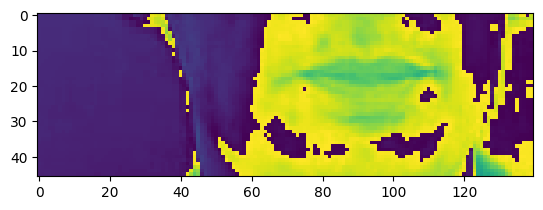

In [72]:
plt.imshow(frames[20])

In [71]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result